In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit

In [2]:
t = 1
T = 2
r = 0.03 
sigma = 0.25

S = 100
Y = 10

## Analytical Solution

## <center> $V = e^{-r  T}\frac{Y_{1} + S_{0}}{r T} \cdot (e^{r T} - 1)$ </center>

In [3]:
Y1 = 10
asian = np.exp(-r * t) * (Y1 + S) / r * t * (np.exp(r * t) - 1)
print("Asian Price: ", asian)

Asian Price:  108.36637698880365


In [4]:
t = 10 / 365 # 10 Day Option
Y1 = 10
asian = np.exp(-r * t) * (Y1 + S) / r * t * (np.exp(r * t) - 1)
print("Asian Price: ", asian)

Asian Price:  0.08253316337253992


#### This looks really cheap, the stock price is at 100. The average should be near 100, why is the price so low? 

In [5]:
t = 1 / 365 # 1 Day Option
Y1 = 10
asian = np.exp(-r * t) * (Y1 + S) / r * t * (np.exp(r * t) - 1)
print("Asian Price: ", asian)

Asian Price:  0.0008256369268228016


#### Shouldn't this be very close to the stock price???!!!!

In [6]:
def asian_price(Y, S, r, t):
    
    return np.exp(-r * t) * (Y + S) / r * t * (np.exp(r * t) - 1)

## Monte Carlo Solution

In [7]:
@jit(nopython = True)
def asian_monte_carlo():
    """
    Computes the price of vanilla asian option using monte carlo methods
    Implements numba for speed
    """
    
    r = 0.03
    sigma = 0.25
    
    t = 1
    T = 2
    
    Y1 = 10
    S = 100
    
    myData = []
    N = np.array([100, 1000, 10000])
    
    for n in N:
    
        U = np.linspace(1, 2, n)
        dt = U[1] - U[0]

        Y2 = np.zeros(n)

        for i in range(n):

            temp = np.zeros(n)        
            rv = np.random.normal(0, 1, n)

            B = np.cumsum(rv * np.sqrt(dt))
            temp = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

            integral = 10

            for k in range(n):

                integral += temp[k] * dt

            Y2[i] = integral
            
        myData.append(Y2)
        
    return myData

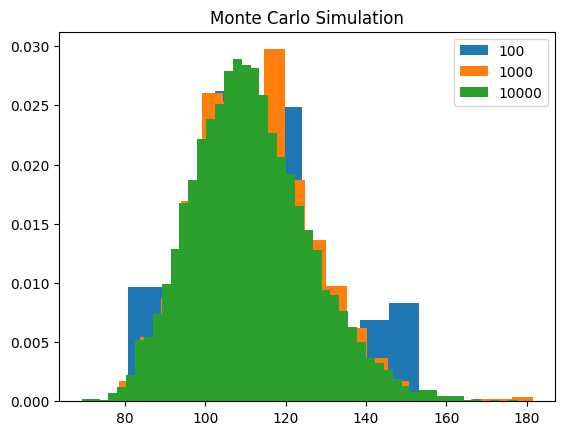

In [8]:
arr = asian_monte_carlo()

plt.hist(arr[0], bins = 10, density = True, label = "100")
plt.hist(arr[1], bins = 20, density = True, label = "1000")
plt.hist(arr[2], bins = 50, density = True, label = "10000")
plt.title("Monte Carlo Simulation")
plt.legend(loc = 'best')
plt.show()

## Convergence Rate

In [9]:
for i in range(len(arr)):
    print("Monte Carlo Price: ", np.exp(-r * t) * np.mean(arr[i]))

Monte Carlo Price:  112.74470585597997
Monte Carlo Price:  112.77980392085654
Monte Carlo Price:  111.49566558217717


#### This convergence is not very good. 

#### The hundred simulations is not good enough, and 1000 and 10000 is also not that good. 

#### Gets very slow, but JIT complier helps a ton. Monte Carlo methods are not very fast for computing option prices. 

## Delta Hedging

#### Delta hedging does not work for exotic options such as Asian options in the traditional sense. The is because the Asian option is path dependent. The function is differentiable, but it does not contain any information about the average price. 

#### According to Hull,  "Asian options are easier to hedge because the payoff becomes progressively more certain as we approach maturity." But they do not have the standard delta. 

#### The average price will not change as much as time to expiration is close to zero because there have been many previous data points and are all weighted equally. 

## <center> $\Delta = e^{-r  T}\frac{1}{r T} \cdot (e^{r T} - 1)$ </center>

In [10]:
t = 1
T = 2
r = 0.03 
sigma = 0.25

S = 100
Y = 10

In [11]:
N = 1000
dt = 1 / N
rv = np.random.normal(0, 1, N)

B = np.cumsum(rv * np.sqrt(dt))
stock1 = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

rv = np.random.normal(0, 1, N)

B = np.cumsum(rv * np.sqrt(dt))
stock2 = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

## Analytical Solution

In [12]:
delta = np.exp(-r * t) * (1 / r * t) * (np.exp(r * t) - 1)
print("Asian Delta: ", delta)

Asian Delta:  0.9851488817163967


In [13]:
alternate_form = (1 / (r * t)) - (np.exp(-r * t) / r * t)
alternate_form

0.9851488817163983

In [14]:
tau = np.linspace(0, 1, N)
deltas = np.zeros(N)
prices = np.zeros(N)
time = tau[::-1]

index = 0
for t in time:
    
    prices[index] = asian_price(10, 100, r, t)
    deltas[index] = np.exp(-r * t) * (1 / r * t) * (np.exp(r * t) - 1)
    index += 1 

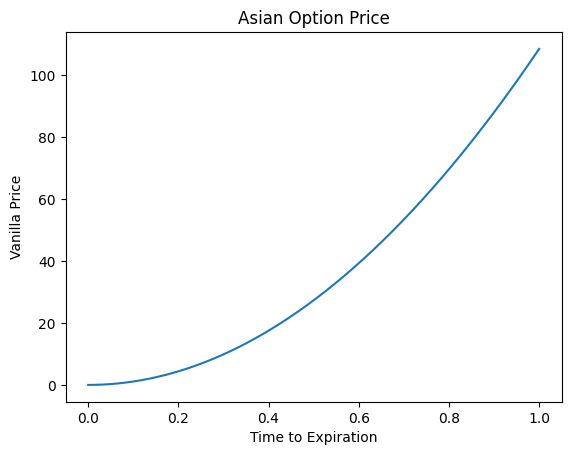

In [15]:
plt.plot(time, prices)
plt.title("Asian Option Price")
plt.xlabel("Time to Expiration")
plt.ylabel("Vanilla Price")
plt.show()

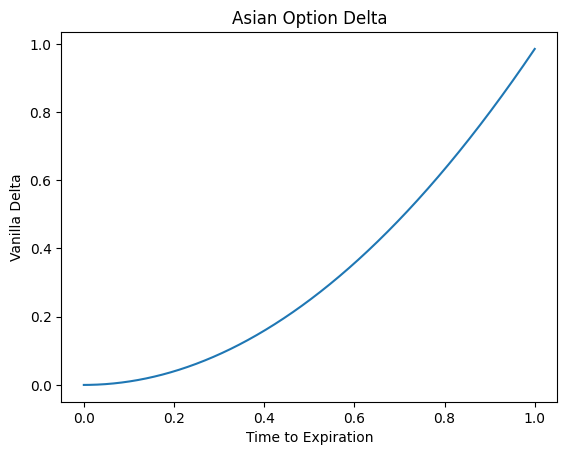

In [16]:
plt.plot(time, deltas)
plt.title("Asian Option Delta")
plt.xlabel("Time to Expiration")
plt.ylabel("Vanilla Delta")
plt.show()

## Self Financing Portfolio

In [17]:
pi1 = np.zeros(N)
pi1[0] = prices[0]
print("Initial Price: ", prices[0])

Initial Price:  108.36637698880365


In [18]:
pi2 = np.zeros(N)
pi2[0] = prices[0]
print("Initial Price: ", prices[0])

Initial Price:  108.36637698880365


In [19]:
y = np.zeros(N)
y[0] = prices[0] - (deltas[0] * stock1[0])

for i in range(1, N):
    
    pi1[i] = (deltas[i - 1] * stock1[i]) + (y[i - 1] * np.exp(-r * dt))
    y[i] = pi1[i] - (deltas[i] * stock1[i])

In [20]:
y = np.zeros(N)
y[0] = prices[0] - (deltas[0] * stock2[0])

for i in range(1, N):
    
    pi2[i] = (deltas[i - 1] * stock2[i]) + (y[i - 1] * np.exp(-r * dt))
    y[i] = pi2[i] - (deltas[i] * stock2[i])

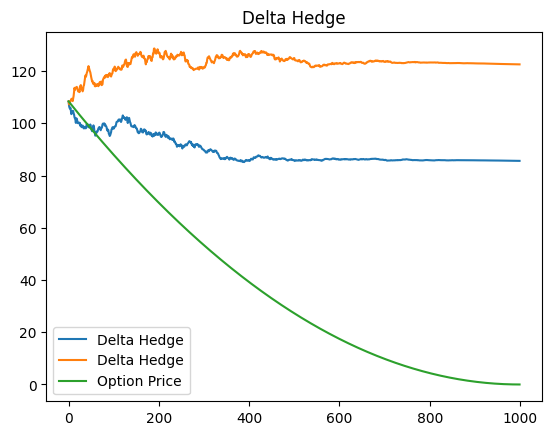

In [21]:
plt.plot(pi1, label = "Delta Hedge")
plt.plot(pi2, label = "Delta Hedge")
plt.plot(prices, label = "Option Price")
plt.title("Delta Hedge")
plt.legend(loc = 'best')
plt.show()

In [22]:
print("Option Price: ", prices[-1])
print("Hedging Process: ", pi1[-1])
print("Hedging Process: ", pi2[-1])

Option Price:  0.0
Hedging Process:  85.61363163978565
Hedging Process:  122.55930433453373


#### This traditional delta hedge does not work. This is because it does not know the average price. 

## Asian Call

## <center> $ V_{t} = (\frac{1}{T} \int_{0}^{T} S_{u} \,du - K)^{+} $ </center>

## Hedging An Asian Call Option

#### 1. Complications arise from path dependence. Asian options and are examples of path-dependent derivatives. The payoff from an Asian option depends on the average price of the underlying asset.

#### 2. For an Asian option the Current Average is the average price since inception. For a new deal (with zero time since inception), the current average is irrelevant.